In [110]:
# !pip install xgboost
# !pip install lightgbm
# !pip install imblearn
# !pip install borutashap
# !pip install eli5

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import random


plt.rcParams["figure.figsize"] = (200,10)


'''
###########################################

Load CSV Dataset to DataFrame

###########################################
'''


time_table = pd.read_csv('Survival_time_event.csv', index_col=0)
clinic_table = pd.read_csv('Clinical_Variables.csv', index_col=0)
genetic_table = pd.read_csv('Genetic_alterations.csv', index_col=0)
survival_treatment_table = pd.read_csv('Label.csv', index_col=0)


'''
###########################################

Correlating Numerical Features of Time Data

-  Dropped Outlier Value

###########################################
'''


print('outlier of time: ')
print(time_table.loc[time_table['time'] < 0, 'time'], end='\n\n')

time_table_outlier = time_table.copy()
time_table_outlier.loc[time_table_outlier['time'] < 0, 'time'] = abs(time_table_outlier.loc[time_table_outlier['time'] < 0, 'time'])
print(time_table_outlier.describe(), end='\n\n')


'''
###########################################

Correlating Numerical Features of Clinic Data

-  Dropped Outlier Value

###########################################
'''


clinic_table_outlier = clinic_table.copy()

# drop outlier
for col in clinic_table_outlier.columns:
    for outlier in range(10,13):
        clinic_table_outlier = clinic_table_outlier.replace(outlier, 9)

# visualize
for col in clinic_table_outlier.columns:
    print('#', col)
    print(clinic_table_outlier[col].value_counts())
    print('-'*20)
   

'''
###########################################

Correlating Numerical Features of Clinic Data

- Normalization

###########################################
'''


clinic_table_normalization = clinic_table_outlier.copy()

# normalization
for col in clinic_table_normalization.columns:
    clinic_table_normalization[col] = (clinic_table_normalization[col] + 1)/10.0
    
# visualize
for col in clinic_table_normalization.columns:
    print('#', col)
    print(clinic_table_normalization[col].value_counts())
    print('-'*20)    
    
    
'''
###########################################

Correlating Numerical Features of Genetic Data

- Normalization

###########################################
'''


genetic_table_normalization = genetic_table.copy()

# normalization
for col in genetic_table_normalization.columns:
    genetic_table_normalization[col] -= 0.5
    
    
print(genetic_table_normalization.head(10))


'''
###########################################

Machine Learning Test Function

###########################################
'''

def TestML(model,selected_genetic):
    train_acc = []
    test_acc = []
    for i in range(20):
        genetic_10 = genetic_table_normalization.copy()
        genetic_10 = genetic_10[selected_genetic]

        input_dataset = pd.concat([survival_treatment_table, time_table_outlier, clinic_table_normalization ,genetic_10], axis=1)
        input_dataset = input_dataset.drop(['event'], axis=1)

        all_index = np.arange(1000)
        train_data, test_data = input_dataset.iloc[all_index[:800],:], input_dataset.iloc[all_index[800:1000],:]
        X_train = train_data.drop(['newlabel'], axis=1)
        Y_train = train_data['newlabel']

        X_test = test_data.drop(['newlabel'], axis=1)
        Y_test = test_data['newlabel']

        model.fit(X_train, Y_train)
        train_acc.append(np.round(model.score(X_train, Y_train), 10))
        
        Y_pred = model.predict(X_test)
        test_acc.append(np.round(accuracy_score(Y_test, Y_pred), 10))
        
        
    print('## Train 정확도: ', np.round(np.max(train_acc), 3), np.round(np.min(train_acc), 3))
    print('## Test 정확도: ', np.round(np.max(test_acc),3), np.round(np.min(test_acc),3))
    print()
    
    return train_acc, test_acc


'''
###########################################

Sorting String Values of Genetic Names Function

###########################################
'''

def sort_genetic_table(genetic_list):
    np_rgl = np.array(genetic_list)
    np_rgl = np.char.replace(np_rgl, 'G', '')
    np_rgl = np.array(np_rgl, dtype='int')
    np_rgl = sorted(np_rgl)
    np_rgl = np.array(np_rgl, dtype='str')
    np_rgl = np.char.add(np.array(['G']*np_rgl.shape[0]),np_rgl)

    return np_rgl.tolist()


'''
###########################################

Selected Genetic Set Test

###########################################
'''


selected_genetic = ['G211', 'G179', 'G80', 'G27', 'G147', 'G139', 'G242', 'G264', 'G290', 'G130']

test_model1 = RandomForestClassifier(n_estimators=60)
test_model2 = lgb.LGBMClassifier(n_estimators=25,num_leaves=64,n_jobs=-1,boost_from_average=False)

print('## test_model1 (Train accuracy가 100인 경우의 모델)')
model1_train, model1_test = TestML(test_model1, selected_genetic)

print('## test_model2 (Train accuracy가 100이 아닌 경우의 모델)')
model2_train, model2_test = TestML(test_model2, selected_genetic)

print(model1_train)
print(model1_test)
print(model2_train)
print(model2_test)

#draw table
model_train_results = np.array([[np.round(np.max(model1_train), 3), np.round(np.min(model1_train), 3)],
                               [np.round(np.max(model1_test), 3),np.round(np.min(model1_test), 3)],
                               [np.round(np.max(model2_train), 3),np.round(np.min(model2_train), 3)],
                               [np.round(np.max(model2_test), 3),np.round(np.min(model2_test), 3)]])

display(pd.DataFrame(model_train_results, columns=['Max', 'Min'],
                     index=['RandomForest Train', 'RandomForest Test','LightGBM Train','LightGBM Test']))
print()
print()

'''
###########################################

Random Genetic Set Test - test_model1: RANDOM FOREST

###########################################
'''


genetic = ['G'+str(i) for i in range(1,301)]


over_genetic = []
random_genetic_list = []

for i in range(100):
    test_genetic = random.sample(genetic, 10)
    print('## 임의의 10개 유전자: ', test_genetic)
    random_genetic_list.extend(test_genetic)
    
    train_accuracy, test_accuracy = TestML(test_model1, test_genetic)

    if np.max(test_accuracy) >= 0.65 or np.min(test_accuracy) >= 0.565:
        print('-----------------Over!-----------------', end='\n\n\n')
        if np.max(test_accuracy) >= 0.65 and np.min(test_accuracy) >= 0.565:
            whatover = 'max&min'
        elif np.max(test_accuracy) >= 0.65:
            whatover = 'max'
        elif np.min(test_accuracy) >= 0.56:
            whatover = 'min'
        over_genetic.append([test_genetic,whatover])

# draw table
print(over_genetic) 

if over_genetic:
    over_genetic_results = np.array(over_genetic)
    pd.set_option('display.max_colwidth', -1)
    display(pd.DataFrame(over_genetic_results, columns=['RandomSet', 'Test Result']))

# draw graph
fig, ax = plt.subplots()

kwargs = dict(alpha=0.3, bins=300)

sorted_random_genetic_list = sort_genetic_table(random_genetic_list)
ax.hist(sorted_random_genetic_list, **dict(alpha=0.3, bins=300), color='r', label='random genetic table')
ax.hist(selected_genetic, **dict(alpha=1, bins=300), color='g', label='selected genetic table')
ax.set(title='Frequency Histogram of Random genetic table', ylabel='Frequency')
fig.savefig('Frequency Histogram of Random genetic table - Acc_100.png', dpi = 200)
plt.show()


'''
###########################################

Random Genetic Set Test - test_model2: LIGHTGBM 

###########################################
'''


over_genetic = []
random_genetic_list = []

for i in range(100):
    test_genetic = random.sample(genetic, 10)
    print('## 임의의 10개 유전자: ', test_genetic)
    random_genetic_list.extend(test_genetic)
    
    train_accuracy, test_accuracy = TestML(test_model2, test_genetic)
    
    if np.max(test_accuracy) >= 0.635:
        print('-----------------Over!-----------------', end='\n\n\n')
        over_genetic.append([test_genetic,np.max(test_accuracy)])

#draw table
print(over_genetic) 

if over_genetic:
    over_genetic_results = np.array(over_genetic)
    pd.set_option('display.max_colwidth', -1)
    display(pd.DataFrame(over_genetic_results, columns=['RandomSet', 'Test Result']))
    

# draw graph
fig, ax = plt.subplots()

kwargs = dict(alpha=0.3, bins=300)

sorted_random_genetic_list = sort_genetic_table(random_genetic_list)
ax.hist(sorted_random_genetic_list, **dict(alpha=0.3, bins=300), color='r', label='random genetic table')
ax.hist(selected_genetic, **dict(alpha=1, bins=300), color='g', label='selected genetic table')
ax.set(title='Frequency Histogram of Random genetic table', ylabel='Frequency')
fig.savefig('Frequency Histogram of Random genetic table - Acc_not_100.png', dpi = 200)
plt.show()



outlier of time: 
905   -7.945621
Name: time, dtype: float64

              time        event
count  1000.000000  1000.000000
mean   51.876125    0.891000   
std    22.122689    0.311795   
min    7.070708     0.000000   
25%    37.401307    1.000000   
50%    47.064712    1.000000   
75%    60.966476    1.000000   
max    217.078908   1.000000   

# Var1
2    235
3    204
1    171
4    139
5    95 
0    57 
6    50 
7    27 
8    13 
9    9  
Name: Var1, dtype: int64
--------------------
# Var2
3    221
2    218
4    163
1    113
5    109
6    65 
0    48 
7    30 
9    20 
8    13 
Name: Var2, dtype: int64
--------------------
# Var3
2    260
3    196
1    156
4    130
5    97 
0    55 
6    55 
7    23 
8    16 
9    12 
Name: Var3, dtype: int64
--------------------
# Var4
2    242
3    195
1    150
4    140
5    106
6    67 
0    36 
7    32 
8    16 
9    16 
Name: Var4, dtype: int64
--------------------
# Var5
2    247
3    223
4    161
5    124
1    76 
6    63 
7    41 
0    28

,Max,Min
RandomForest Train,1.000,1.000
RandomForest Test,0.610,0.555
LightGBM Train,0.892,0.892
LightGBM Test,0.635,0.635




## 임의의 10개 유전자:  ['G291', 'G62', 'G112', 'G12', 'G177', 'G286', 'G34', 'G103', 'G238', 'G268']
## Train 정확도:  1.0 1.0
## Test 정확도:  0.6 0.55

## 임의의 10개 유전자:  ['G85', 'G146', 'G71', 'G43', 'G147', 'G42', 'G200', 'G129', 'G171', 'G295']
## Train 정확도:  1.0 1.0
## Test 정확도:  0.615 0.555

## 임의의 10개 유전자:  ['G289', 'G27', 'G272', 'G223', 'G124', 'G69', 'G198', 'G238', 'G2', 'G269']
## Train 정확도:  1.0 1.0
## Test 정확도:  0.605 0.535

## 임의의 10개 유전자:  ['G68', 'G222', 'G286', 'G272', 'G65', 'G11', 'G8', 'G143', 'G186', 'G215']
## Train 정확도:  1.0 1.0
## Test 정확도:  0.605 0.525

## 임의의 10개 유전자:  ['G297', 'G43', 'G51', 'G9', 'G184', 'G258', 'G69', 'G109', 'G291', 'G166']
## Train 정확도:  1.0 1.0
## Test 정확도:  0.6 0.52

## 임의의 10개 유전자:  ['G75', 'G93', 'G48', 'G163', 'G283', 'G43', 'G59', 'G108', 'G233', 'G164']
## Train 정확도:  1.0 1.0
## Test 정확도:  0.59 0.52

## 임의의 10개 유전자:  ['G297', 'G21', 'G58', 'G275', 'G291', 'G200', 'G160', 'G212', 'G5', 'G29']
## Train 정확도:  1.0 0.999
## Test 정확도:  0.605 0.54



KeyboardInterrupt: 

In [ ]:
'''
###########################################

ML Feature Selection Test - Genetic Top 10 x 3

###########################################
'''


test_genetic = ['G238', 'G47', 'G290', 'G242', 'G162', 'G130', 'G65', 'G11', 'G300', 'G139']
print('## ML로 뽑은 10개 유전자: ', test_genetic)

model1_train, model1_test = TestML(test_model1, test_genetic)
model2_train, model2_test = TestML(test_model2, test_genetic)


#draw table
model_train_results = np.array([[np.round(np.max(model1_train), 3), np.round(np.min(model1_train), 3)],
                               [np.round(np.max(model1_test), 3),np.round(np.min(model1_test), 3)],
                               [np.round(np.max(model2_train), 3),np.round(np.min(model2_train), 3)],
                               [np.round(np.max(model2_test), 3),np.round(np.min(model2_test), 3)]])

display(pd.DataFrame(model_train_results, columns=['Max', 'Min'],
                     index=['RandomForest Train', 'RandomForest Test','LightGBM Train','LightGBM Test']))


test_genetic = ['G238', 'G191', 'G242', 'G200', 'G130', 'G166', 'G124', 'G57', 'G263', 'G146']
print('## ML로 뽑은 10개 유전자: ', test_genetic)

model1_train, model1_test = TestML(test_model1, test_genetic)
model2_train, model2_test = TestML(test_model2, test_genetic)


#draw table
model_train_results = np.array([[np.round(np.max(model1_train), 3), np.round(np.min(model1_train), 3)],
                               [np.round(np.max(model1_test), 3),np.round(np.min(model1_test), 3)],
                               [np.round(np.max(model2_train), 3),np.round(np.min(model2_train), 3)],
                               [np.round(np.max(model2_test), 3),np.round(np.min(model2_test), 3)]])

display(pd.DataFrame(model_train_results, columns=['Max', 'Min'],
                     index=['RandomForest Train', 'RandomForest Test','LightGBM Train','LightGBM Test']))


test_genetic = ['G200', 'G18', 'G75', 'G6', 'G112', 'G148', 'G284', 'G9', 'G221', 'G187']
print('## ML로 뽑은 10개 유전자: ', test_genetic)

model1_train, model1_test = TestML(test_model1, test_genetic)
model2_train, model2_test = TestML(test_model2, test_genetic)

#draw table
model_train_results = np.array([[np.round(np.max(model1_train), 3), np.round(np.min(model1_train), 3)],
                               [np.round(np.max(model1_test), 3),np.round(np.min(model1_test), 3)],
                               [np.round(np.max(model2_train), 3),np.round(np.min(model2_train), 3)],
                               [np.round(np.max(model2_test), 3),np.round(np.min(model2_test), 3)]])

display(pd.DataFrame(model_train_results, columns=['Max', 'Min'],
                     index=['RandomForest Train', 'RandomForest Test','LightGBM Train','LightGBM Test']))


In [56]:
# '''
# 20번 돌린 것을 100번 돌린 경우

# '''
# selected_genetic = ['G211', 'G179', 'G80', 'G27', 'G147', 'G139', 'G242', 'G264', 'G290', 'G130']


# print('## test_model1 (Train accuracy가 100인 경우의 모델)')
# train_result, test_result = [], []
# for i in range(100):
#     tmp1, tmp2 = TestML(test_model1, selected_genetic)
#     train_result.extend(tmp1)
#     test_result.extend(tmp2)
    
# print('## Train 평균 정확도: ', np.round(np.mean(train_result), 3))
# print('## Test 평균 정확도: ', np.round(np.mean(test_result),3))
# print()

# print('## test_model2 (Train accuracy가 100이 아닌 경우의 모델)')
# train_result, test_result = [], []
# for i in range(100):
#     tmp1, tmp2 = TestML(test_model2, selected_genetic)
#     train_result.extend(tmp1)
#     test_result.extend(tmp2)
    
# print('## Train 평균 정확도: ', np.round(np.mean(train_result), 3))
# print('## Test 평균 정확도: ', np.round(np.mean(test_result),3))

## test_model1 (Train accuracy가 100인 경우의 모델)
## Train 평균 정확도:  99.998
## Test 평균 정확도:  0.584

## test_model2 (Train accuracy가 100이 아닌 경우의 모델)
## Train 평균 정확도:  92.75
## Test 평균 정확도:  0.63


In [402]:
'''
20번 돌린 것을 100번 돌린 경우

'''
selected_genetic = ['G203', 'G195', 'G297', 'G208', 'G196', 'G115', 'G290', 'G235', 'G253', 'G240']


print('## test_model2 (Train accuracy가 100이 아닌 경우의 모델)')
train_result, test_result = [], []
for i in range(100):
    tmp1, tmp2 = TestML(test_model2, selected_genetic)
    train_result.extend(tmp1)
    test_result.extend(tmp2)
    
print('## Train 평균 정확도: ', np.round(np.mean(train_result), 3))
print('## Test 평균 정확도: ', np.round(np.mean(test_result),3))

## test_model2 (Train accuracy가 100이 아닌 경우의 모델)
## Train 평균 정확도:  89.375
## Test 평균 정확도:  0.645


In [404]:
'''
20번 돌린 것을 100번 돌린 경우

'''
selected_genetic = ['G211', 'G179', 'G80', 'G27', 'G147', 'G139', 'G242', 'G264', 'G290', 'G130']


print('## test_model2 (Train accuracy가 100이 아닌 경우의 모델)')
train_result, test_result = [], []
for i in range(100):
    tmp1, tmp2 = TestML(test_model2, selected_genetic)
    train_result.extend(tmp1)
    test_result.extend(tmp2)
    
print('## Train 평균 정확도: ', np.round(np.mean(train_result), 3))
print('## Test 평균 정확도: ', np.round(np.mean(test_result),3))

## test_model2 (Train accuracy가 100이 아닌 경우의 모델)
## Train 평균 정확도:  89.25
## Test 평균 정확도:  0.635


In [118]:
import ast

f = open('./result/Train&Test_Random100Set-Acc_100.txt', 'r', encoding = 'utf-8')
# fw = open('./result/Train&Test_Random100Set-Acc_100_new.txt', 'w', encoding = 'utf-8')
random_genetic_list = []
Train_max_list = []
Train_min_list = []
Test_max_list = []
Test_min_list = []
idx= 0

while True:
    line = f.readline()
    if not line: break       
    print(idx, line)
      
    if line.find('임의의') != -1:
        random_genetic_list.extend(ast.literal_eval(line[line.find('['):-1]))
#         fw.write(line)
        
    elif line.find('Train') != -1:
        train_str = line[line.find(':') + 1:].split()
#         print(float(train_str[0])*0.01, float(train_str[1])*0.01)
        Train_max_list.append(float(train_str[0])*0.01)
        Train_min_list.append(float(train_str[1])*0.01)
        new_line = line.replace(train_str[0], str(float(train_str[0])*0.01)).replace(train_str[1], str(float(train_str[1])*0.01))
        
#         fw.write(new_line)
        
    elif line.find('Test') != -1:
        test_str = line[line.find(':') + 1:].split()
#         print(test_str)
        Test_max_list.append(float(test_str[0]))
        Test_min_list.append(float(test_str[1]))
#         fw.write(line)
#     else:
#         fw.write(line)
        
    idx += 1  

f.close()

0 ## 임의의 10개 유전자:  ['G29', 'G157', 'G273', 'G178', 'G195', 'G214', 'G93', 'G67', 'G201', 'G142']

1 ## Train 정확도:  1.0 1.0

2 ## Test 정확도:  0.605 0.53

3 

4 ## 임의의 10개 유전자:  ['G270', 'G229', 'G46', 'G217', 'G279', 'G221', 'G258', 'G136', 'G15', 'G21']

5 ## Train 정확도:  1.0 1.0

6 ## Test 정확도:  0.625 0.51

7 

8 ## 임의의 10개 유전자:  ['G100', 'G214', 'G40', 'G151', 'G76', 'G159', 'G105', 'G23', 'G290', 'G114']

9 ## Train 정확도:  1.0 1.0

10 ## Test 정확도:  0.62 0.535

11 

12 ## 임의의 10개 유전자:  ['G126', 'G90', 'G294', 'G34', 'G96', 'G151', 'G264', 'G98', 'G30', 'G82']

13 ## Train 정확도:  1.0 1.0

14 ## Test 정확도:  0.61 0.535

15 

16 ## 임의의 10개 유전자:  ['G81', 'G65', 'G144', 'G294', 'G20', 'G264', 'G162', 'G58', 'G206', 'G170']

17 ## Train 정확도:  1.0 1.0

18 ## Test 정확도:  0.61 0.54

19 

20 ## 임의의 10개 유전자:  ['G46', 'G15', 'G54', 'G16', 'G171', 'G144', 'G154', 'G183', 'G12', 'G296']

21 ## Train 정확도:  1.0 1.0

22 ## Test 정확도:  0.615 0.555

23 

24 ## 임의의 10개 유전자:  ['G201', 'G239', 'G111', 'G113', 'G1

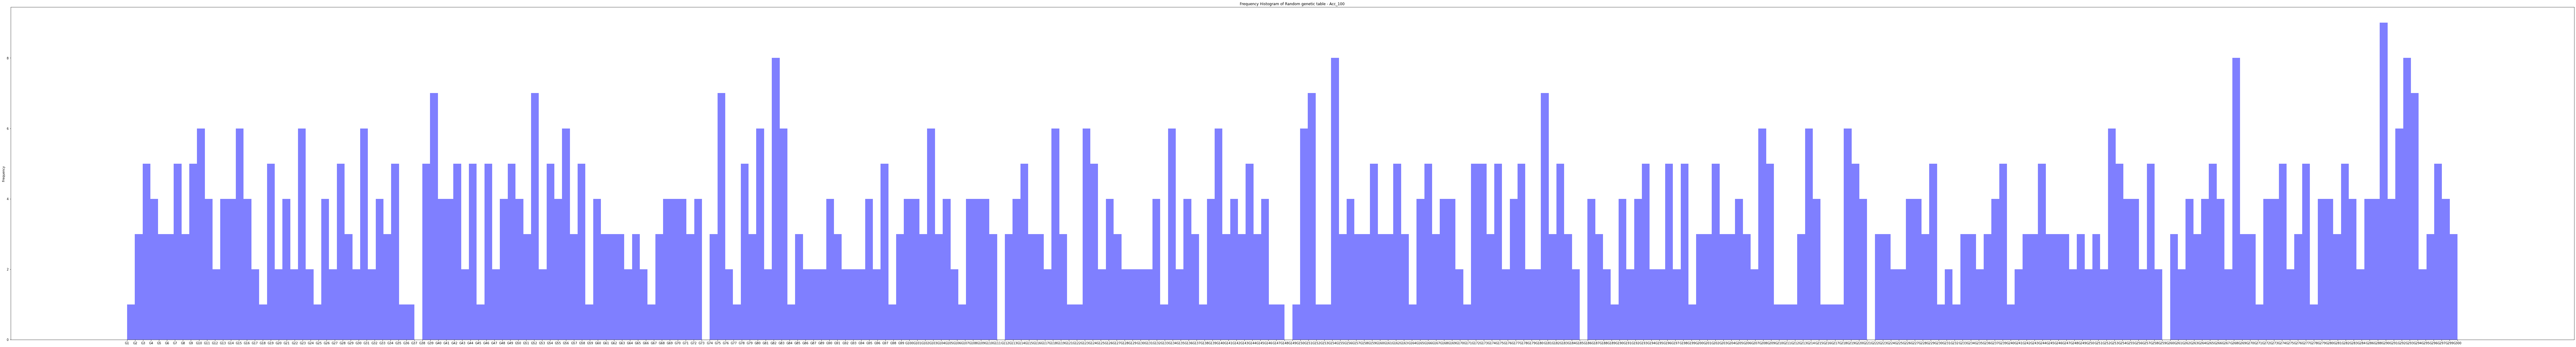

In [126]:
# draw graph
plt.rcParams["figure.figsize"] = (150,20)
fig, ax = plt.subplots()

kwargs = dict(alpha=0.3, bins=300)

sorted_random_genetic_list = sort_genetic_table(random_genetic_list)
ax.hist(sorted_random_genetic_list, **dict(alpha=0.5, bins=300), color='b', label='random genetic table')
# ax.hist(selected_genetic, **dict(alpha=1, bins=300), color='g', label='selected genetic table')
ax.set(title='Frequency Histogram of Random genetic table - Acc_100', ylabel='Frequency')

fig.savefig('Frequency Histogram of Random genetic table - Acc_100.png', dpi = 200)
plt.show()

In [52]:
len(Train_max_list)

100

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.legend as legend
plt.rcParams["figure.figsize"] = (20,10)
index = range(1, 101)
# l0 = plt.plot(0,1.0, 'ro')
# l1 = plt.plot(0,1.0, 'go')
l2 = plt.plot(index,[0.65]*100, 'ro-')
l3 = plt.plot(index,[0.565]*100, 'go-')
# l4 = plt.plot(index, Train_max_list, 'r^-')
# l5 = plt.plot(index, Train_min_list, 'g^-')
l6 = plt.plot(index, Test_max_list, 'b^-')
l7 = plt.plot(index, Test_min_list, 'y^-')
plt.legend(l2+l3+l6+l7, ['selected_test_max','selected_test_min',
                         'random_test_max','random_test_min'])

In [130]:
f.close()

In [127]:
import ast

f = open('./result/Train&Test_Random100Set-Acc_not_100.txt', 'r', encoding = 'utf-8')
# fw = open('./result/Train&Test_Random100Set-Acc_not_100_new.txt', 'w', encoding = 'utf-8')
random_genetic_list = []
Train_max_list = []
Train_min_list = []
Test_max_list = []
Test_min_list = []
idx= 0

while True:
    line = f.readline()
    if not line: break       
    print(idx, line)
      
    if line.find('임의의') != -1:
        random_genetic_list.extend(ast.literal_eval(line[line.find('['):-1]))
#         fw.write(line)
        
    elif line.find('Train') != -1:
        train_str = line[line.find(':') + 1:].split()
        print(float(train_str[0])*0.01, float(train_str[1])*0.01)
        a = float(train_str[0])*0.01
        b = float(train_str[1])*0.01
        Train_max_list.append(float(train_str[0])*0.01)
        Train_min_list.append(float(train_str[1])*0.01)
        new_line = line.replace(train_str[0], 
                                str(round(a,3))).replace(train_str[1], str(round(b,3)))
        
#         fw.write(new_line)
        
    elif line.find('Test') != -1:
        test_str = line[line.find(':') + 1:].split()
#         print(test_str)
        Test_max_list.append(float(test_str[0]))
        Test_min_list.append(float(test_str[1]))
#         fw.write(line)
#     else:
#         fw.write(line)
        
    idx += 1  

f.close()

0 ## 임의의 10개 유전자:  ['G252', 'G195', 'G65', 'G253', 'G40', 'G255', 'G4', 'G59', 'G186', 'G140']

1 ## Train 정확도:  0.894 0.894

0.00894 0.00894
2 ## Test 정확도:  0.58 0.58

3 

4 ## 임의의 10개 유전자:  ['G45', 'G101', 'G166', 'G199', 'G52', 'G72', 'G250', 'G68', 'G255', 'G137']

5 ## Train 정확도:  0.893 0.893

0.00893 0.00893
6 ## Test 정확도:  0.625 0.625

7 

8 ## 임의의 10개 유전자:  ['G132', 'G98', 'G226', 'G286', 'G292', 'G134', 'G168', 'G257', 'G61', 'G190']

9 ## Train 정확도:  0.888 0.888

0.00888 0.00888
10 ## Test 정확도:  0.595 0.595

11 

12 ## 임의의 10개 유전자:  ['G115', 'G127', 'G257', 'G193', 'G179', 'G228', 'G141', 'G181', 'G217', 'G190']

13 ## Train 정확도:  0.901 0.901

0.00901 0.00901
14 ## Test 정확도:  0.61 0.61

15 

16 ## 임의의 10개 유전자:  ['G213', 'G179', 'G141', 'G31', 'G28', 'G168', 'G139', 'G237', 'G45', 'G3']

17 ## Train 정확도:  0.89 0.89

0.0089 0.0089
18 ## Test 정확도:  0.625 0.625

19 

20 ## 임의의 10개 유전자:  ['G237', 'G120', 'G77', 'G255', 'G32', 'G297', 'G129', 'G96', 'G126', 'G196']

21 ## Train 정확도

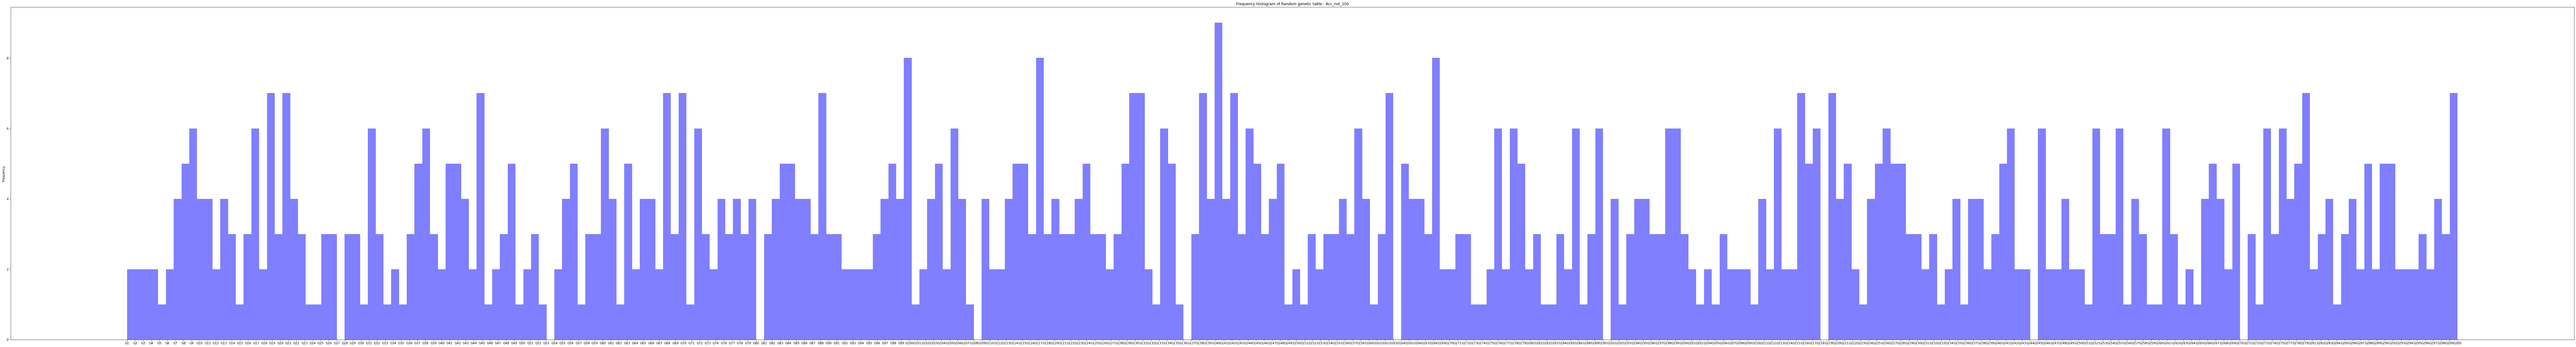

In [129]:
# draw graph
plt.rcParams["figure.figsize"] = (150,20)
fig, ax = plt.subplots()

kwargs = dict(alpha=0.3, bins=300)

sorted_random_genetic_list = sort_genetic_table(random_genetic_list)
ax.hist(sorted_random_genetic_list, **dict(alpha=0.5, bins=300), color='b', label='random genetic table')
# ax.hist(selected_genetic, **dict(alpha=1, bins=300), color='g', label='selected genetic table')
ax.set(title='Frequency Histogram of Random genetic table - Acc_not_100', ylabel='Frequency')

fig.savefig('Frequency Histogram of Random genetic table - Acc_100.png', dpi = 200)
plt.show()

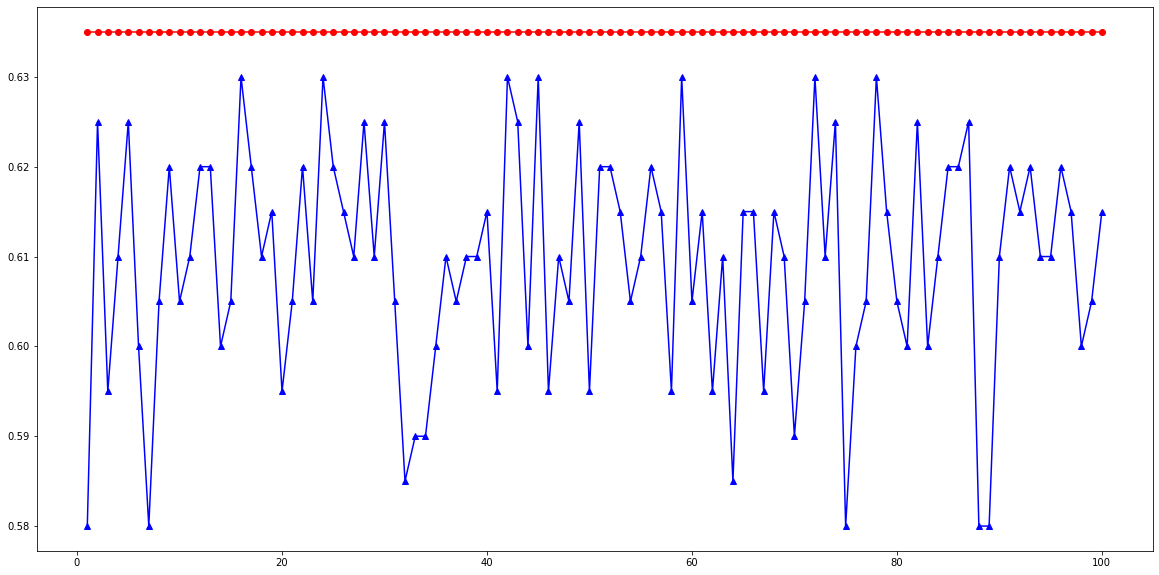

In [97]:
import matplotlib.pyplot as plt
import matplotlib.legend as legend
plt.rcParams["figure.figsize"] = (20,10)
index = range(1, 101)
# l0 = plt.plot(0,1.0, 'ro')
# l1 = plt.plot(0,1.0, 'go')
l2 = plt.plot(index,[0.635]*100, 'ro-')
# l4 = plt.plot(index, Train_max_list, 'r^-')
# l5 = plt.plot(index, Train_min_list, 'g^-')
l6 = plt.plot(index, Test_max_list, 'b^-')

# plt.legend(l2+l6, ['selected_test',
#                          'random_test'])

# plt.legend(l0+l1+l2+l3+l4+l5+l6+l7, ['selected_train_max','selected_train_min','selected_test_max','selected_test_min',
#                          'random_train_max','random_train_min','random_test_max','random_test_min'])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.legend as legend
plt.rcParams["figure.figsize"] = (20,10)
index = range(1, 101)
# l0 = plt.plot(0,1.0, 'ro')
# l1 = plt.plot(0,1.0, 'go')
l2 = plt.plot(index,[0.63]*100, 'ro-')
# l4 = plt.plot(index, Train_max_list, 'r^-')
# l5 = plt.plot(index, Train_min_list, 'g^-')
l6 = plt.plot(index, Test_max_list, 'b^-')

plt.legend(l2+l6, ['selected_test',
                         'random_test'])